In [3]:
import numpy as np
from sklearn.decomposition import PCA
import scipy.io as sio
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import os
import random
from random import shuffle
from skimage.transform import rotate
import scipy.ndimage
import scipy as sp
from scipy import fftpack
from keras.models import load_model
from keras.utils import np_utils
from sklearn.metrics import classification_report, confusion_matrix
import itertools
import spectral

In [7]:
def loadIndianPinesData():
    data_path = os.path.join(os.getcwd(),'data')
    data = sio.loadmat("../../Datasets/Indian pines/Indian_pines_corrected.mat")['indian_pines_corrected']
    labels = sio.loadmat("../../Datasets/Indian pines/Indian_pines_gt.mat")['indian_pines_gt']
    
    return data, labels

def splitTrainTestSet(X, y, testRatio=0.10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=345,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test


def dost_bw(l):
    out = np.zeros(int(2*np.log2(l)))
    l1 = np.arange(np.log2(l)-2,-1,-1)
    l2 = np.arange(0,np.log2(l)-1)
    out[1:int(1+np.log2(l)-1)]=l1
    out[-int(np.log2(l)-1):]=l2
    
    out = np.exp2(out).astype(np.int16)
    return out

def dost(inp):
    l = inp.shape[0]
    fft_inp = fftpack.fftshift(fftpack.fft(fftpack.ifftshift(inp,axes=0),axis=0),axes=0)
    #plt.figure(figsize = (30,5))
    #ax = np.linspace(-512,511,2**10)
    #plt.plot(ax,fft_inp[0,:])
    bw_inp = dost_bw(l)
#     print(bw_inp)
    k = 0
    dost_inp = np.zeros_like(fft_inp)

    for r in bw_inp:
        if(r==1):
            dost_inp[k,:] = fft_inp[k,:]
            k = k+r
        else:
            dost_inp[k:r+k,:] = fftpack.fftshift(fftpack.ifft(fftpack.ifftshift(fft_inp[k:r+k,:],axes=0),axis=0),axes=0)
            k = k+r

#     plt.plot(fft_inp)
    #plt.figure(figsize = (20,5))
    #plt.plot(np.abs(dost_inp[0,:]))
    
    
    return dost_inp
    
    
def oversampleWeakClasses(X, y):
    uniqueLabels, labelCounts = np.unique(y, return_counts=True)
    maxCount = np.max(labelCounts)
    labelInverseRatios = maxCount / labelCounts  
    # repeat for every label and concat
    newX = X[y == uniqueLabels[0], :, :, :].repeat(round(labelInverseRatios[0]), axis=0)
    newY = y[y == uniqueLabels[0]].repeat(round(labelInverseRatios[0]), axis=0)
    for label, labelInverseRatio in zip(uniqueLabels[1:], labelInverseRatios[1:]):
        cX = X[y== label,:,:,:].repeat(round(labelInverseRatio), axis=0)
        cY = y[y == label].repeat(round(labelInverseRatio), axis=0)
        newX = np.concatenate((newX, cX))
        newY = np.concatenate((newY, cY))
    np.random.seed(seed=42)
    rand_perm = np.random.permutation(newY.shape[0])
    newX = newX[rand_perm, :, :, :]
    newY = newY[rand_perm]
    return newX, newY


def standartizeData(X):
    newX = np.reshape(X, (-1, X.shape[2]))
    scaler = preprocessing.StandardScaler().fit(newX)  
    newX = scaler.transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1],X.shape[2]))
    return newX, scaler

def applyPCA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca

def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

def createPatches(X, y, windowSize=5, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels


def AugmentData(X_train):
    for i in range(int(X_train.shape[0]/2)):
        patch = X_train[i,:,:,:]
        num = random.randint(0,2)
        if (num == 0):
            
            flipped_patch = np.flipud(patch)
        if (num == 1):
            
            flipped_patch = np.fliplr(patch)
        if (num == 2):
            
            no = random.randrange(-180,180,30)
            flipped_patch = scipy.ndimage.interpolation.rotate(patch, no,axes=(1, 0),
                                                               reshape=False, output=None, order=3, mode='constant', cval=0.0, prefilter=False)
    
    
    patch2 = flipped_patch
    X_train[i,:,:,:] = patch2
    
    return X_train


def savePreprocessedData(X_trainPatches, X_testPatches, y_trainPatches, y_testPatches, windowSize,dost_applied=False, wasPCAapplied = False, numPCAComponents = 0, testRatio = 0.25):
    if dost_applied:
        if wasPCAapplied:
            with open("../data/XtrainWindowSize" + str(windowSize) + "PCA" + str(numPCAComponents) + "testRatio" + str(testRatio) + "_dost.npy", 'wb+') as outfile:
                np.save(outfile, X_trainPatches)
            with open("../data/XtestWindowSize" + str(windowSize) + "PCA" + str(numPCAComponents) + "testRatio" + str(testRatio) + "_dost.npy", 'wb+') as outfile:
                np.save(outfile, X_testPatches)
            with open("../data/ytrainWindowSize" + str(windowSize) + "PCA" + str(numPCAComponents) + "testRatio" + str(testRatio) + "_dost.npy", 'wb+') as outfile:
                np.save(outfile, y_trainPatches)
            with open("../data/ytestWindowSize" + str(windowSize) + "PCA" + str(numPCAComponents) + "testRatio" + str(testRatio) + "_dost.npy", 'wb+') as outfile:
                np.save(outfile, y_testPatches)
        else:
            with open("../data/XtrainWindowSize" + str(windowSize) + "_dost.npy", 'bw+') as outfile:
                np.save(outfile, X_trainPatches)
            with open("../data/XtestWindowSize" + str(windowSize) + "_dost.npy", 'bw+') as outfile:
                np.save(outfile, X_testPatches)
            with open("../data/ytrainWindowSize" + str(windowSize) + "_dost.npy", 'bw+') as outfile:
                np.save(outfile, y_trainPatches)
            with open("../data/ytestWindowSize" + str(windowSize) + "_dost.npy", 'bw+') as outfile:
                np.save(outfile, y_testPatches)
    else:
        if wasPCAapplied:
            with open("../data/XtrainWindowSize" + str(windowSize) + "PCA" + str(numPCAComponents) + "testRatio" + str(testRatio) + ".npy", 'wb+') as outfile:
                np.save(outfile, X_trainPatches)
            with open("../data/XtestWindowSize" + str(windowSize) + "PCA" + str(numPCAComponents) + "testRatio" + str(testRatio) + ".npy", 'wb+') as outfile:
                np.save(outfile, X_testPatches)
            with open("../data/ytrainWindowSize" + str(windowSize) + "PCA" + str(numPCAComponents) + "testRatio" + str(testRatio) + ".npy", 'wb+') as outfile:
                np.save(outfile, y_trainPatches)
            with open("../data/ytestWindowSize" + str(windowSize) + "PCA" + str(numPCAComponents) + "testRatio" + str(testRatio) + ".npy", 'wb+') as outfile:
                np.save(outfile, y_testPatches)
        else:
            with open("../data/XtrainWindowSize" + str(windowSize) + ".npy", 'bw+') as outfile:
                np.save(outfile, X_trainPatches)
            with open("../data/XtestWindowSize" + str(windowSize) + ".npy", 'bw+') as outfile:
                np.save(outfile, X_testPatches)
            with open("../data/ytrainWindowSize" + str(windowSize) + ".npy", 'bw+') as outfile:
                np.save(outfile, y_trainPatches)
            with open("../data/ytestWindowSize" + str(windowSize) + ".npy", 'bw+') as outfile:
                np.save(outfile, y_testPatches)
                




In [69]:
# Global Variables
numComponents = 64
windowSize = 7
testRatio = 0.95
dost_ = False

In [70]:
X, y = loadIndianPinesData()
print("Shape of X : ",end='')
print(X.shape)

Shape of X : (145, 145, 200)


In [71]:
if dost_:
    X_dost = np.zeros([X.shape[0],X.shape[1],256])
    X_dost[:,:,:200] = X

    X_ = np.abs(dost(X_dost.reshape([-1,X_dost.shape[2]],order='F').T).T.reshape(X_dost.shape,order='F'))
else:
    X_ = X

In [75]:
X_.shape

(145, 145, 200)

In [72]:
X_pca,pca = applyPCA(X_,numComponents=numComponents)

In [73]:
XPatches, yPatches = createPatches(X_pca, y, windowSize=windowSize)
X_train, X_test, y_train, y_test = splitTrainTestSet(XPatches, yPatches, testRatio)
X_train, y_train = oversampleWeakClasses(X_train, y_train)
X_train = AugmentData(X_train)

In [74]:
print("X_train : {}".format(X_train.shape))
print("y_train : {}".format(y_train.shape))
print("X_test : {}".format(X_test.shape))
print("y_test : {}".format(y_test.shape))

X_train : (1981, 7, 7, 64)
y_train : (1981,)
X_test : (9737, 7, 7, 64)
y_test : (9737,)


In [13]:
import numpy as np
import scipy
import os
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D,Conv3D,MaxPooling3D
from keras.optimizers import SGD
from keras import backend as K
K.set_image_dim_ordering('th')
from keras.utils import np_utils
import keras
#from sklearn.cross_validation import StratifiedKFold

In [1]:
def load_train_data(windowSize,testRatio,PCA_applied,DOST_applied,numPCAcomponents):
    pass

In [76]:
y_train = np_utils.to_categorical(y_train)

In [77]:
input_shape = X_train[0].shape
print("Input Shape : {}".format(X_train[...][0].shape))

Input Shape : (7, 7, 64)


In [78]:
C1 = 64

In [79]:
# Define the model
model = Sequential()

model.add(Conv2D(2*C1, (3, 3),data_format="channels_last", activation='relu', input_shape=input_shape))
model.add(Dropout(0.4))
# model.add(MaxPooling3D(pool_size=()))
model.add(Conv2D(C1, (3, 3), data_format="channels_last",activation='relu'))
model.add(Dropout(0.4))
# model.add(MaxPooling3D((2,2,2)))
# model.add(Conv3D(C1, (2,3, 3), activation='relu'))
# model.add(Dropout(0.25))





model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(16, activation='softmax'))

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 5, 5, 128)         73856     
_________________________________________________________________
dropout_7 (Dropout)          (None, 5, 5, 128)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 3, 3, 64)          73792     
_________________________________________________________________
dropout_8 (Dropout)          (None, 3, 3, 64)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               147712    
_________________________________________________________________
dropout_9 (Dropout)          (None, 256)               0         
__________

In [80]:
sgd = SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [81]:
filepath = "../models/conv_v2.h5"
history = model.fit(X_train,
    y_train,
    batch_size=16,
    epochs=50,
    #show_accuracy=False,
#     verbose=2,
    validation_split = 0.1,
    callbacks = [
        keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
#         keras.callbacks.EarlyStopping(monitor='val_acc', patience=10, verbose=0, mode='auto'),
#         keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto')
    ]
    )

Train on 1782 samples, validate on 199 samples
Epoch 1/50
1782/1782 [==============================] - 2s 936us/step - loss: 3.1326 - acc: 0.0870 - val_loss: 2.4351 - val_acc: 0.3015
Epoch 2/50
1782/1782 [==============================] - 1s 760us/step - loss: 2.7287 - acc: 0.1689 - val_loss: 2.2191 - val_acc: 0.3719
Epoch 3/50
1782/1782 [==============================] - 1s 738us/step - loss: 2.5119 - acc: 0.2329 - val_loss: 2.0716 - val_acc: 0.4322
Epoch 4/50
1782/1782 [==============================] - 1s 727us/step - loss: 2.3654 - acc: 0.2705 - val_loss: 1.9518 - val_acc: 0.4724
Epoch 5/50
1782/1782 [==============================] - 1s 738us/step - loss: 2.2559 - acc: 0.3025 - val_loss: 1.8583 - val_acc: 0.5276
Epoch 6/50
1782/1782 [==============================] - 1s 723us/step - loss: 2.1469 - acc: 0.3339 - val_loss: 1.7705 - val_acc: 0.5829
Epoch 7/50
1782/1782 [==============================] - 1s 716us/step - loss: 2.0548 - acc: 0.3597 - val_loss: 1.6788 - val_acc: 0.6080
E

In [68]:
model.save(filepath=filepath)

In [26]:
def reports (X_test,y_test,model):
    Y_pred = model.predict(X_test,batch_size=8)
    y_pred = np.argmax(Y_pred, axis=1)
    target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
               ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed', 
                'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
               'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
               'Stone-Steel-Towers']

    
    classification = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    score = model.evaluate(X_test, y_test, batch_size=8)
    Test_Loss =  score[0]*100
    Test_accuracy = score[1]*100
    
    return classification, confusion, Test_Loss, Test_accuracy



In [82]:
y_test_ = np_utils.to_categorical(y_test)

In [83]:
classification, confusion, Test_loss, Test_accuracy = reports(X_test,y_test_,model)
classification = str(classification)
confusion = str(confusion)
numComponents = 64
file_name = 'report' + "WindowSize" + str(windowSize) + "PCA" + str(numComponents) + "testRatio" + str(testRatio) +".txt"
with open(file_name, 'w+') as x_file:
    x_file.write('{} Test loss (%)'.format(Test_loss))
    x_file.write('\n')
    x_file.write('{} Test accuracy (%)'.format(Test_accuracy))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{}'.format(classification))
    x_file.write('\n')
    x_file.write('{}'.format(confusion))

9737/9737 [==============================] - 3s 268us/step


In [84]:
!cat reportWindowSize7PCA64testRatio0.95.txt

64.97189714751707 Test loss (%)
79.40844202526446 Test accuracy (%)

                              precision    recall  f1-score   support

                     Alfalfa       1.00      0.09      0.17        44
                 Corn-notill       0.74      0.77      0.75      1357
                Corn-mintill       0.72      0.65      0.68       789
                        Corn       0.84      0.48      0.61       225
               Grass-pasture       0.95      0.94      0.95       459
                 Grass-trees       0.93      1.00      0.96       693
         Grass-pasture-mowed       1.00      0.07      0.14        27
               Hay-windrowed       0.88      1.00      0.94       454
                        Oats       1.00      0.16      0.27        19
              Soybean-notill       0.59      0.84      0.70       923
             Soybean-mintill       0.83      0.66      0.74      2332
               Soybean-clean       0.64      0.83      0.72       563
                    

In [85]:
XPatches, yPatches = createPatches(X_pca, y, windowSize=windowSize,removeZeroLabels=False)

In [86]:
XPatches.shape

(21025, 7, 7, 64)

In [87]:
predictions = model.predict_classes(XPatches,batch_size=16)+1

In [88]:
pred_proba = model.predict_proba(XPatches,batch_size=16).reshape((145,145,16))

In [89]:
predictions[yPatches==0] = 0

In [90]:
np.sum(predictions[yPatches!=0] == yPatches[yPatches!=0])

8207

In [91]:
predictions.shape

(21025,)

In [41]:
145*145

21025

In [42]:
pred_map = predictions.reshape((145,145))

ImageView object:
  Interpolation       :  <default>

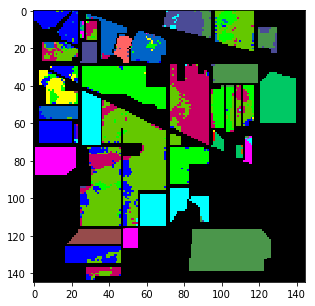

In [44]:
spectral.imshow(classes = pred_map,figsize =(5,5))

In [54]:
def wls_filter(img,lambda_,alpha,L):
    
    epsilon = 1e-4
    (r,c)=img.shape
    k = r*c
    
    dy = np.diff(L,1,0)
    dy = -lambda_/(np.power(np.abs(dy),alpha)+epsilon)
    dy = np.lib.pad(dy,[(0,1),(0,0)],'constant',constant_values=0)
    dy = dy.flatten('F')
    
    dx = np.diff(L,1,1)
    dx = -lambda_/(np.power(np.abs(dx),alpha)+epsilon)
    dx = np.lib.pad(dx,[(0,0),(0,1)],'constant',constant_values=0)
    dx = dx.flatten('F')
    
    B = np.array([dx,dy])
    A = sp.sparse.diags(B,[-r,-1],(k,k))
    
    e = dx
    w = np.pad(dx,[(r,0)],'constant',constant_values=0)[:-r]
    s = dy
    n = np.pad(dy,[(1,0)],'constant',constant_values=0)[:-1]
    
    D = 1-(e+w+s+n)
    
    A = A + A.T + sp.sparse.diags(D.reshape(1,-1),[0],(k,k))
    
    result = sp.sparse.linalg.spsolve(A,img.reshape((-1,1),order = 'F'))
    result = result.reshape((r,c),order='F')
    
    return result


#%%
def bt_wls(Y,prediction,errMat,lamda_,alpha):
    
    (m,n)=prediction.shape
    bands = Y.shape[2]
#     Y = Y.reshape((m,n,bands),order = 'F')
    
    numClasses = errMat.shape[2]
#     errCube = errMat.reshape((m,n,numClasses),order = 'F')
    errCube = errMat[...]
    errCube = (errCube-np.min(errCube))/(np.max(errCube)-np.min(errCube))
    
    guidanceImage = applyPCA(Y,1)[0].reshape((m,n)) 
    
    #guidanceImage = np.mean(np.log(Y.astype(np.double)+0.0001),2)
    for i in range(numClasses):
        slc = errCube[:,:,i]
        slc[np.logical_not(prediction==i+1)]=0
        slc = wls_filter(slc,lamda_,alpha,guidanceImage)
        errCube[:,:,i]=slc
       
    new_prediction = np.argmax(errCube,2)+1
    new_prediction[prediction==0] = 0
    return new_prediction   

In [92]:
pred_dost = bt_wls(X,pred_map,pred_proba,0.3,0.8)

ImageView object:
  Interpolation       :  <default>

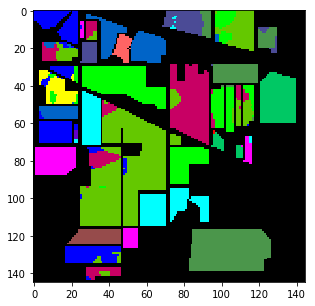

In [93]:
spectral.imshow(classes = pred_dost,figsize =(5,5))

ImageView object:
  Interpolation       :  <default>

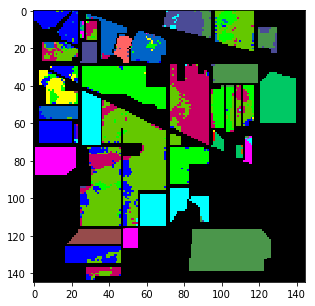

In [94]:
spectral.imshow(classes = pred_map,figsize =(5,5))

In [1]:
pred_map.dtypr

NameError: name 'pred_map' is not defined

In [97]:
%matplotlib inline
import matplotlib.pyplot as plt

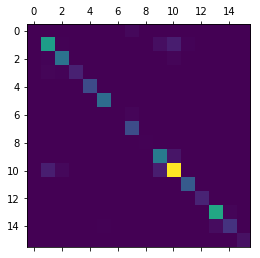

In [98]:
plt.matshow(confusion_matrix(y[y!=0].reshape(-1),pred_dost[y!=0].reshape(-1)))

In [95]:
np.sum(pred_dost.reshape(-1)[yPatches!=0] == yPatches[yPatches!=0])

9145

In [63]:
pred_dost[yPatches!=0].reshape(-1,1).shape

IndexError: boolean index did not match indexed array along dimension 0; dimension is 145 but corresponding boolean dimension is 21025

In [67]:
8602/(X_train.shape[0]+X_test.shape[0])

0.734084314729476